In [1]:
from utils import *
from sklearn.metrics import mean_absolute_error as mae


In [2]:
df = load_file("DW_df")
df.shape

(5733526, 2)

In [ ]:
df.iloc[8000:15000,:].plot()

In [ ]:
analyze_appliance_signature(df, df.columns[1], 10)

In [ ]:
# def remove_off_steps(df,on_threshold = 40,limit = 2000):
#     status = df.iloc[:,1].values > on_threshold
#     indexes = []
#     for i in range(limit, len(status)-limit):
#         if status[i] == True or np.sum(status[i-limit//2:i+limit//2]) != 0:
#             indexes.append(i)
#     df_indexes = df.index[indexes]
#     df = df.loc[df_indexes]
#     analyze_appliance_signature(df, df.columns[1], on_threshold)
#     return df

# df_removed = remove_off_steps(df)

In [ ]:
# df_removed.shape

In [ ]:
# plt.plot(df_removed.head(2000))

In [3]:
df_norm, normalizer = fit_normalize_df(df)

In [4]:
import torch
from torch import nn
import random

import torchvision
from torch.utils.data import Dataset, DataLoader

def get_device():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    return device

device = get_device()
device

device(type='cuda', index=0)

In [5]:
class NILMDataset(Dataset):
    def __init__(self, df, window_size=512, stride=100):
        self.data = df
        self.window_size = window_size
        self.nrows = df.shape[0]
        self.stride = stride

    def __len__(self):     
        return (self.nrows-self.window_size+1)//self.stride

    def __getitem__(self, i):
        i = self.stride*i
        aggregate = self.data.iloc[i:i+self.window_size,0].values.reshape(1,-1)
        appliance = self.data.iloc[i:i+self.window_size,1].values.reshape(1,-1)
        return aggregate, appliance

train_size = 0.7
pos = int(train_size*df.shape[0])
df_train = df_norm.iloc[:pos,:]

train_set = NILMDataset(df_train)
train_generator = DataLoader(train_set, batch_size=500, shuffle=False)

In [6]:
len(train_generator)

81

In [7]:
for x,y in train_generator:
    break
x.size(), y.size()


(torch.Size([500, 1, 512]), torch.Size([500, 1, 512]))

In [8]:
# UNet components
def crop(series, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle = series.shape[2] // 2
    starting = middle - round(new_shape[2] / 2)
    final = starting + new_shape[2]
    cropped_series = series[:, :, starting:final]
    return cropped_series

class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm1d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout(p=0.2)
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        self.conv1 = nn.Conv1d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv1d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm1d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout(p=0.2)
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x],1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv1d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

In [9]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return xn

In [ ]:
from torchsummary import summary
model = UNet(1,1)
summary(model, (1,512), batch_size=500, device="cpu")

In [10]:
n_epochs = 20
input_dim = 1
output_dim = 1
visulize_step = 20
lr = 0.001

model = UNet(input_dim,output_dim).to(device)

criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm1d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

model = model.apply(weights_init)

In [11]:
def validate_model(df,model,val_size=0.1):
    train_size = 1-val_size
    pos = int(train_size*df.shape[0])
    df_test = df.iloc[pos:,:]
    df_test_norm = normalizer.transform(df_test)

    class NILMTestDataset(Dataset):
        def __init__(self, df, window_size=512, stride=512):
            self.data = df
            self.window_size = window_size
            self.nrows = df.shape[0]
            self.stride = stride

        def __len__(self):     
            return (self.nrows-self.window_size+1)//self.stride

        def __getitem__(self, i):
            i = self.stride*i
            aggregate = self.data.iloc[i:i+self.window_size,0].values.reshape(1,-1)
            appliance = self.data.iloc[i:i+self.window_size,1].values.reshape(1,-1)
            return aggregate, appliance

    test_set = NILMTestDataset(df_test_norm)
    test_generator = DataLoader(test_set, batch_size=500, shuffle=False)
    
    preds = []
    reals = []
    aggs = []

    with torch.no_grad():
        for aggregate, appliance in test_generator:
            agg = aggregate.numpy().reshape(-1)
            pred = model(aggregate.to(torch.float32).to(device))
            pred = pred.detach().cpu().numpy().reshape(-1)
            real = appliance.numpy().reshape(-1)

            aggs += agg.tolist()
            preds += pred.tolist()
            reals += real.tolist()
            
    aggs_inv = [x*normalizer.sd.values[0] + normalizer.mu.values[0] for x in aggs]
    reals_inv = [x*normalizer.sd.values[1] + normalizer.mu.values[1] for x in reals]
    preds_inv = [x*normalizer.sd.values[1] + normalizer.mu.values[1] for x in preds]
    s = mae(reals_inv, preds_inv)
    print(f"Validation set MAE loss: {s:.5f}")
    
    return

In [12]:
for epoch in range(n_epochs):
    
    running_loss = 0.0
    for i, (mains, appliance) in enumerate(train_generator):
        mains = mains.to(torch.float32).to(device)
        appliance = appliance.to(torch.float32).to(device)
        
        # zero the parameter gradients
        optim.zero_grad()
        outputs = model(mains)
        loss = criterion(outputs, appliance)
        loss.backward()
        optim.step()
        
#         # print statistics
#         running_loss += loss.item()
#         if i % len(train_generator) == len(train_generator)-1:
#             print(f"[Epoch {epoch+1:3.0f}/{n_epochs}] Batch loss: {running_loss/len(train_generator):.5f}")
#             running_loss = 0.0
            
        # print statistics
        running_loss += loss.item()
        if i % visulize_step == visulize_step-1:
            print(f"[Epoch{epoch+1:3.0f}/{n_epochs}] Batch {i+1:.0f}/{len(train_generator)} loss: {running_loss/visulize_step:.5f}")
            running_loss = 0.0
        
#         if i==1:
        if i % len(train_generator) == len(train_generator)-1:
            validate_model(df, model)
        
print('Finished Training')

C:\Users\z1061\Anaconda3\envs\pytorchenv_gpu\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch  1/20] Batch 20/81 loss: 0.94105
[Epoch  1/20] Batch 40/81 loss: 0.88517
[Epoch  1/20] Batch 60/81 loss: 0.61112
[Epoch  1/20] Batch 80/81 loss: 0.92508
Validation set MAE loss: 88.30824
[Epoch  2/20] Batch 20/81 loss: 0.63467
[Epoch  2/20] Batch 40/81 loss: 0.54209
[Epoch  2/20] Batch 60/81 loss: 0.36837
[Epoch  2/20] Batch 80/81 loss: 0.60198
Validation set MAE loss: 76.85956
[Epoch  3/20] Batch 20/81 loss: 0.39820
[Epoch  3/20] Batch 40/81 loss: 0.39011
[Epoch  3/20] Batch 60/81 loss: 0.35956
[Epoch  3/20] Batch 80/81 loss: 0.54552
Validation set MAE loss: 63.73337
[Epoch  4/20] Batch 20/81 loss: 0.37703
[Epoch  4/20] Batch 40/81 loss: 0.32810
[Epoch  4/20] Batch 60/81 loss: 0.33618
[Epoch  4/20] Batch 80/81 loss: 0.48876
Validation set MAE loss: 65.13090
[Epoch  5/20] Batch 20/81 loss: 0.32569
[Epoch  5/20] Batch 40/81 loss: 0.31576
[Epoch  5/20] Batch 60/81 loss: 0.29509
[Epoch  5/20] Batch 80/81 loss: 0.46657
Validation set MAE loss: 73.91923
[Epoch  6/20] Batch 20/81 loss

In [13]:
torch.save(model, f"./cnn_DW_unet.pt")

In [14]:
train_size = 0.9
pos = int(train_size*df.shape[0])
df_test = df.iloc[pos:,:]
df_test_norm = normalizer.transform(df_test)

class NILMTestDataset(Dataset):
    def __init__(self, df, window_size=512, stride=512):
        self.data = df
        self.window_size = window_size
        self.nrows = df.shape[0]
        self.stride = stride
  
    def __len__(self):     
        return (self.nrows-self.window_size+1)//self.stride

    def __getitem__(self, i):
        i = self.stride*i
        aggregate = self.data.iloc[i:i+self.window_size,0].values.reshape(1,-1)
        appliance = self.data.iloc[i:i+self.window_size,1].values.reshape(1,-1)
        return aggregate, appliance

test_set = NILMTestDataset(df_test_norm)
test_generator = DataLoader(test_set, batch_size=100, shuffle=False)

In [15]:
preds = []
reals = []
aggs = []

with torch.no_grad():
    for aggregate, appliance in test_generator:
        agg = aggregate.numpy().reshape(-1)
        pred = model(aggregate.to(torch.float32).to(device))
        pred = pred.detach().cpu().numpy().reshape(-1)
        real = appliance.numpy().reshape(-1)
        
        aggs += agg.tolist()
        preds += pred.tolist()
        reals += real.tolist()


In [16]:
aggs_inv = [x*normalizer.sd.values[0] + normalizer.mu.values[0] for x in aggs]
reals_inv = [x*normalizer.sd.values[1] + normalizer.mu.values[1] for x in reals]
preds_inv = [x*normalizer.sd.values[1] + normalizer.mu.values[1] for x in preds]


In [17]:
mae(reals_inv, preds_inv)

57.52718025829517

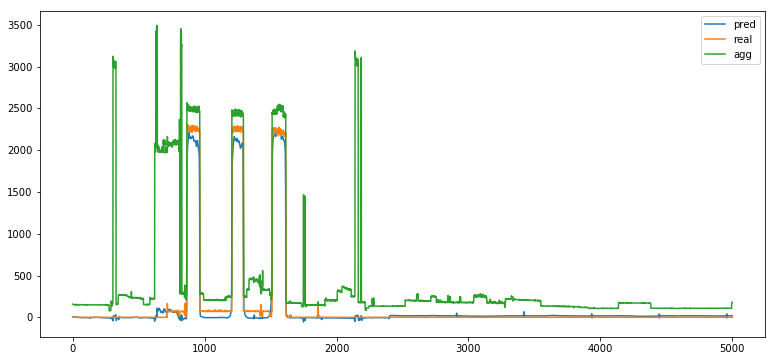

In [29]:
s =100000
t = s+5000
plt.plot(preds_inv[s:t], label="pred")
plt.plot(reals_inv[s:t], label="real")
plt.plot(aggs_inv[s:t], label="agg")
plt.legend()
plt.show()